## Dependencies

In [1]:
!pip install emoji --quiet
!pip install pysentimiento --quiet
!pip3 install googletrans==3.1.0a0 --quiet
!pip install google-play-scraper --quiet
!pip install Sastrawi --quiet

     |████████████████████████████████| 240 kB 7.5 MB/s 
     |████████████████████████████████| 312 kB 12.2 MB/s 
     |████████████████████████████████| 3.3 MB 7.5 MB/s 
     |████████████████████████████████| 175 kB 33.4 MB/s 
     |████████████████████████████████| 3.3 MB 49.8 MB/s 
     |████████████████████████████████| 880 kB 71.9 MB/s 
     |████████████████████████████████| 182 kB 65.5 MB/s 
     |████████████████████████████████| 115 kB 51.0 MB/s 
     |████████████████████████████████| 212 kB 60.1 MB/s 
     |████████████████████████████████| 127 kB 56.2 MB/s 
     |████████████████████████████████| 55 kB 2.5 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.4 MB 15.4 MB/s 
     |████████████████████████████████| 65 kB 3.6 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 209 kB 6.9 MB/s 


In [2]:
import pandas as pd
import wordcloud
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
from tqdm import tqdm
from random import sample
import tensorflow as tf
tqdm.pandas()
warnings.filterwarnings("ignore")
import json
import regex
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from google_play_scraper import app
from googletrans import Translator, constants
import string
import re
import emoji
import string
import operator
from pysentimiento import create_analyzer
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


## Preparation

In [ ]:
def translate_en(df):
  with tf.device('/device:GPU:0'):
    translator = Translator()
    df['tweet'] = df['tweet'].progress_apply(lambda x: translator.translate(x, src="id", des='en').text)
    return df

In [ ]:
def process_df(df, stopword_add=[]):
  # Change the reviews type to string
  df['tweet'] = df['tweet'].astype(str)
  #Lowercase all reviews
  df['tweet']= df['tweet'].apply(lambda x: x.lower())

  df['tweet']=df.tweet.apply(lambda x: str(emoji.demojize(x)))
  df['tweet'] = df['tweet'].str.replace('::',' ')

  punc = string.punctuation
  df['tweet'] = df.tweet.apply(lambda x: x.translate(str.maketrans('', '', punc)))

  print('Process 1',df.shape)
  # stopword_add is list containing string
  stop_words=stopwords.words('indonesian')
  stop_words.extend(stopword_add)
  df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

  print('Process 2',df.shape)
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()

  # import Sastrawi package
  from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

  # create stemmer
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()

  def lemmatize_text(text):
      return ' '.join([stemmer.stem(w) for w in w_tokenizer.tokenize(text)])

  df['tweet'] = df.tweet.progress_apply(lemmatize_text)
  print('Process 3',df.shape)
  return df

In [ ]:
def predict_sentiment(df):
  analyzer = create_analyzer(task="sentiment", lang="en")
  def pysentimento_sent(x):
    if str(x)!='nan':
      score = list(analyzer.predict(x).probas.values())
      index, _ = max(enumerate(score), key=operator.itemgetter(1))
      return index
    return 'NULL'
  df['pysentiment']=df.tweet.progress_apply(lambda x: pysentimento_sent(x))
  return df

In [ ]:
def predict_hate_speech(df):
  hate_speech_analyzer = create_analyzer(task="hate_speech", lang="en")
  def pysentimento_hate_speech(x):
    if str(x)!='nan':
      score = list(hate_speech_analyzer.predict(x).probas.values())
      index = ' '.join(np.where(np.any(np.array([score])>0.3, axis=0))[0].astype(str).tolist())
      return index
    return 'NULL'
  df['hate_speech']=df.tweet.progress_apply(lambda x: pysentimento_hate_speech(x))
  return df

## EDA

In [ ]:
df1 = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_week1.xlsx')
df2 = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_week2.xlsx')
df_merge = pd.concat([df1,df2], axis=0, ignore_index=True)

In [ ]:
pd.to_datetime(df_merge.date)

0        2022-09-14 19:17:00
1        2022-09-14 19:16:46
2        2022-09-14 19:16:33
3        2022-09-14 19:15:52
4        2022-09-14 19:14:04
                 ...        
131218   2022-09-15 00:00:12
131219   2022-09-15 00:00:03
131220   2022-09-15 00:00:01
131221   2022-09-15 00:00:01
131222   2022-09-15 00:00:00
Name: date, Length: 131223, dtype: datetime64[ns]

In [ ]:
df_merge['date'] = pd.to_datetime(df_merge.date)

In [ ]:
df_merge.dtypes

date        datetime64[ns]
username            object
tweet               object
dtype: object

In [ ]:
df_merge['date'] = df_merge.date.dt.date

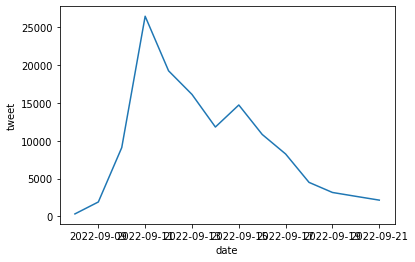

In [ ]:
tmp = df_merge.groupby('date')['tweet'].count().reset_index()
sns.lineplot(tmp.date, tmp.tweet)
# tmp

In [ ]:
df_merge['tweet'] = df_merge['tweet'].fillna("NULL")

In [ ]:
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('minister')

0         False
1         False
2         False
3         False
4         False
          ...  
131218    False
131219    False
131220    False
131221    False
131222    False
Name: tweet, Length: 131223, dtype: bool

In [ ]:
(df_merge['tweet'].apply(lambda x: x.lower()).str.contains('minister') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('presiden') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('jokowi') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('govern') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('cominfo') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('dpr') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('ministry') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('polic') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('mahfud') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('luhut') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('buzzer')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('indonesia')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('sambo') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('munir')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('anis')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('anies')).sum()

45842

In [ ]:
((df_merge['tweet'].apply(lambda x: x.lower()).str.contains('data') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('security') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('hacker') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('system') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('leak') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('account') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('personal'))
&
(df_merge['tweet'].apply(lambda x: x.lower()).str.contains('minister') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('presiden') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('jokowi') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('govern') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('cominfo') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('dpr') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('ministry') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('polic') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('mahfud') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('luhut') |\
df_merge['tweet'].apply(lambda x: x.lower()).str.contains('buzzer')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('indonesia')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('sambo') |\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('munir')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('anis')|\
 df_merge['tweet'].apply(lambda x: x.lower()).str.contains('anies'))).sum()

15723

In [ ]:
tmp.index.min()

datetime.date(2022, 9, 8)

## Bagi Tugas

In [ ]:
df1 = pd.read_json('/content/drive/MyDrive/MPPI/BjorkaTweet_Week02.json').T
df2 = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week2.xlsx')

In [ ]:
df3 = pd.read_json('/content/drive/MyDrive/MPPI/BjorkaTweet_Week01.json').T
df4 = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week1.xlsx')

In [ ]:
df4= df4.fillna('NULL')

In [ ]:
df_pemerintah2 = df4[(df4['tweet'].apply(lambda x: x.lower()).str.contains('minister') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('presiden') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('jokowi') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('govern') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('cominfo') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('dpr') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('ministry') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('polic') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('mahfud') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('luhut') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('buzzer')|\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('indonesia')|\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('sambo') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('munir')|\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('anis')|\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('anies'))]

In [ ]:
df_pemerintah2.shape

(25621, 4)

In [ ]:
df_bjorka2 = df4[(df4['tweet'].apply(lambda x: x.lower()).str.contains('security') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('hacker') |\
df4['tweet'].apply(lambda x: x.lower()).str.contains('system') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('leak') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('account') |\
 df4['tweet'].apply(lambda x: x.lower()).str.contains('personal') |\
  df4['tweet'].apply(lambda x: x.lower()).str.contains('cyber') |\
   df4['tweet'].apply(lambda x: x.lower()).str.contains('document')|\
    df4['tweet'].apply(lambda x: x.lower()).str.contains('data'))]

In [ ]:
df_bjorka2.shape

(22908, 4)

In [ ]:
tmp1 = pd.concat([df1,df2['pysentiment']], axis=1).loc[df_pemerintah1.index].reset_index(drop=True)
tmp2 = pd.concat([df3,df4['pysentiment']], axis=1).loc[df_pemerintah2.index].reset_index(drop=True)
all1 = pd.concat([tmp1,tmp2], ignore_index=True)
all1.to_excel(f'/content/drive/MyDrive/MPPI/df_pemerintah.xlsx', index=False)

In [ ]:
tmp1 = pd.concat([df1,df2['pysentiment']], axis=1).loc[df_bjorka1.index].reset_index(drop=True)
tmp2 = pd.concat([df3,df4['pysentiment']], axis=1).loc[df_bjorka2.index].reset_index(drop=True)
all1 = pd.concat([tmp1,tmp2], ignore_index=True)
all1.to_excel(f'/content/drive/MyDrive/MPPI/df_bjorka.xlsx', index=False)

## Main

In [ ]:
tmp = pd.read_excel('/content/drive/MyDrive/MPPI/df_bjorka.xlsx')

In [ ]:
tmp.pysentiment.value_counts(normalize=True)

1    0.538323
0    0.418939
2    0.042737
Name: pysentiment, dtype: float64

In [ ]:
from transformers import pipeline
from sklearn.metrics import classification_report

In [ ]:
tmp = tmp.dropna()

In [ ]:
print(classification_report(tmp.iloc[:,0], tmp.iloc[:,1], digits=4))

              precision    recall  f1-score   support

         0.0     0.6000    0.7373    0.6616       118
         1.0     0.0000    0.0000    0.0000         1
         3.0     0.1429    0.0727    0.0964        55
         4.0     0.0000    0.0000    0.0000        11
         6.0     0.0588    0.2000    0.0909         5

    accuracy                         0.4842       190
   macro avg     0.1603    0.2020    0.1698       190
weighted avg     0.4155    0.4842    0.4412       190



In [ ]:
print(classification_report(tmp.iloc[:,0], tmp.iloc[:,1], digits=4))

              precision    recall  f1-score   support

         0.0     0.7368    0.4118    0.5283        34
         1.0     0.3333    1.0000    0.5000         1
         3.0     0.4286    0.4737    0.4500        19
         4.0     0.1818    0.6667    0.2857         3
         6.0     0.0000    0.0000    0.0000         1

    accuracy                         0.4483        58
   macro avg     0.3361    0.5104    0.3528        58
weighted avg     0.5875    0.4483    0.4805        58



In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MPPI/df_pemerintah.xlsx')[:100]
# with tf.device('/device:GPU:0'):
  # df = translate_en(df)
# df.to_excel(f'/content/drive/MyDrive/MPPI/df_pemerintah.xlsx', index=False)

In [ ]:
from pysentimiento.preprocessing import preprocess_tweet
# df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_pemerintah.xlsx')
def tweet_process(x):
   return preprocess_tweet(str(x), lang="en")
df['tweet'] = df.tweet.progress_apply(tweet_process)

100%|██████████| 100/100 [00:00<00:00, 7956.26it/s]


In [ ]:
with tf.device('/device:GPU:0'):
  # df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_week1.xlsx')
  df = process_df(df)
  # df = translate_id(df)
  # df.to_excel(f'/content/drive/MyDrive/MPPI/df_process_pemerintah.xlsx', index=False)

Process 1 (100, 4)
Process 2 (100, 4)


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Process 3 (100, 4)


In [ ]:
df.to_excel('a.xlsx')

In [ ]:
!pip install deep_translator --quiet

     |████████████████████████████████| 128 kB 22.9 MB/s 


In [ ]:
from deep_translator import GoogleTranslator

In [ ]:
import tensorflow as tf
def translate_id(df):
  with tf.device('/device:GPU:0'):
    translator = Translator()
    df['tweet'] = df['tweet'].progress_apply(lambda x: GoogleTranslator('en','id').translate(x))
    return df

In [ ]:
with tf.device('/device:GPU:0'):
  df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_process_week2.xlsx')
  df = predict_sentiment(df)
  # df.to_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week2.xlsx', index=False)

In [ ]:
with tf.device('/device:GPU:0'):
  df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week2.xlsx')
  df = predict_hate_speech(df)
  df.to_excel(f'/content/drive/MyDrive/MPPI/df_hatespeech_week2.xlsx', index=False)

In [ ]:
with tf.device('/device:GPU:0'):
  df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week1.xlsx')
  df = predict_hate_speech(df)
  # df.to_excel(f'/content/drive/MyDrive/MPPI/df_hatespeech_week1.xlsx', index=False)

In [ ]:
from datasets import load_dataset
df = pd.read_excel('/content/drive/MyDrive/MPPI/df_sentiment_week1.xlsx')
# dataset = load_dataset("yelp_review_full")
# dataset["train"][100]

In [ ]:
df.head(1)

,date,username,tweet,pysentiment
0,"Wednesday 14 Sep 2022, 19:17:00",marhairi,user caught bjorka smooth,1.0


In [ ]:
df = df.dropna(subset=['tweet'])

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_data = tokenizer(df["tweet"].values.tolist(), return_tensors="np", padding=True)

labels = np.array(df["pysentiment"].values.tolist())  # Label is already an array of 0 and 1

In [ ]:
labels

array([1., 0., 1., ..., 0., 1., 0.])

In [ ]:
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam

# Load and compile our model
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")
# Lower learning rates are often better for fine-tuning transformers
model.compile(optimizer=Adam(3e-5))

model.fit(tokenized_data['input_ids'].tolist(), labels.tolist(), verbose=1)

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/

TypeError: ignored

In [ ]:
print(base_output[0])

KerasTensor(type_spec=TensorSpec(shape=(None, 50, 768), dtype=tf.float32, name=None), name='bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'bert'")


In [ ]:
print(base_output[1])

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='bert/pooler/dense/Tanh:0', description="created by layer 'bert'")


In [ ]:
import tensorflow as tf
import transformers
print(tf.__version__)
print(transformers.__version__)
MAX_LEN = 193
model_path = 'saved_model/temp_model'
ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
mask = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
token_type_ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
base_model = transformers.TFBertModel.from_pretrained("bert-base-cased"
, output_hidden_states=False)
base_output = base_model.bert([ids, mask, token_type_ids])
seq_out, _ = base_output[0], base_output[1]
base_model.trainable = False
model = tf.keras.models.Model(inputs=[ids, mask, token_type_ids], outputs=[seq_out])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())
# model.save(model_path)
# model = tf.keras.models.load_model(model_path)

2.9.2
4.13.0


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/bert-base-cased/resolve/main/tf_model.h5 from cache at /root/.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 193)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 193)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 193)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_16[0][0]',               
                                thPoolingAndCrossAt               'input_17[0][0]',         

In [ ]:
tokenized_data

In [ ]:
model.fit((tokenized_data['input_ids'], tokenized_data['attention_mask'],
           tokenized_data['token_type_ids']), labels, verbose=1)

## Insight

In [3]:
df = pd.read_excel(f'/content/drive/MyDrive/MPPI/df_sentiment_week2.xlsx')
tmp = (df.pysentiment.value_counts(normalize=True).rename(index=dict(zip([2,1,0],['Positive',"Neutral","Negative"])))*100).round(2)
tmp.astype(str)+'%'

Neutral     65.74%
Negative    25.66%
Positive     8.61%
Name: pysentiment, dtype: object

In [10]:
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['https','co','bjorka','like','know','really','still'])

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

text_pos = df.tweet.dropna().values

cv1=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3), min_df=5, max_features=500)
# cv2=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3), min_df=5, max_features=500)

X = cv1.fit_transform(text_pos)
X = X.toarray()
bow1=pd.DataFrame(X, columns = cv1.get_feature_names())

# X = cv2.fit_transform(text_neg)
# X = X.toarray()
# bow2=pd.DataFrame(X, columns = cv2.get_feature_names())

# bow1 = bow1[bow1.columns[[len(i.split(' '))>=1 for i in bow1.columns]]]
# bow2 = bow2[bow2.columns[[len(i.split(' '))>=1 for i in bow2.columns]]]

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# text_pos = df[df.tweet==2].content.values
# text_neg = df[df.tweet==0].content.values

# cv1=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3), min_df=5, max_features=500)
# cv2=CountVectorizer( stop_words=stop_words, ngram_range=(1, 3), min_df=5, max_features=500)

# X = cv1.fit_transform(text_pos)
# X = X.toarray()
# bow1=pd.DataFrame(X, columns = cv1.get_feature_names())

# X = cv2.fit_transform(text_neg)
# X = X.toarray()
# bow2=pd.DataFrame(X, columns = cv2.get_feature_names())

# bow1 = bow1[bow1.columns[[len(i.split(' '))>=1 for i in bow1.columns]]]
# bow2 = bow2[bow2.columns[[len(i.split(' '))>=1 for i in bow2.columns]]]

In [ ]:
# bow1.pop('door application')
# bow2.pop('door application')
# bow2.pop('even though')
# bow2.pop('foldedhands foldedhands foldedhands')
# bow2.pop('foldedhands foldedhands')
# bow1.pop('thumbsup thumbsup thumbsup')
# print(' ')

In [8]:
wordcloud_pos = WordCloud(width = 800, height = 800,min_word_length =3,
                      background_color='white',stopwords=stop_words)

wordcloud_pos.generate_from_frequencies(dict(bow1.sum(axis=0)))

# wordcloud_neg = WordCloud(width = 800, height = 800,min_word_length =3,
#                       background_color='white',stopwords=stop_words)

# wordcloud_neg.generate_from_frequencies(dict(bow2.sum(axis=0)))

wordcloud_pos.to_file("wordcloud.png")
# wordcloud_neg.to_file(f"/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_neg.png")

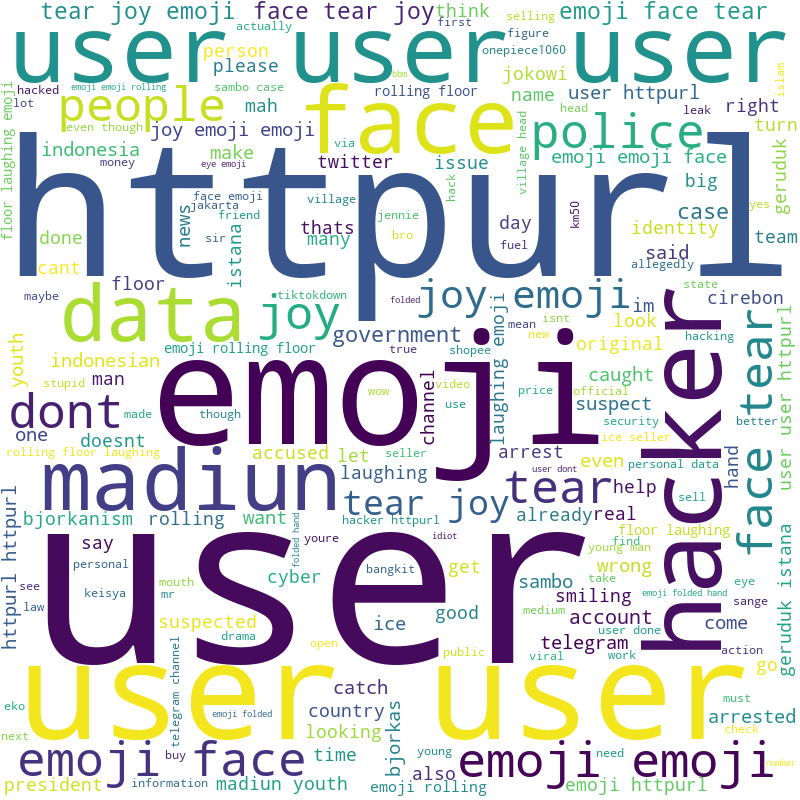

<Figure size 720x720 with 0 Axes>

In [9]:
import cv2
from google.colab.patches import cv2_imshow
plt.figure(figsize=(10,10))
img = cv2.imread(f'wordcloud.png')
cv2_imshow(img)
# print()
# img = cv2.imread(f'/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_neg.png')
# cv2_imshow(img);

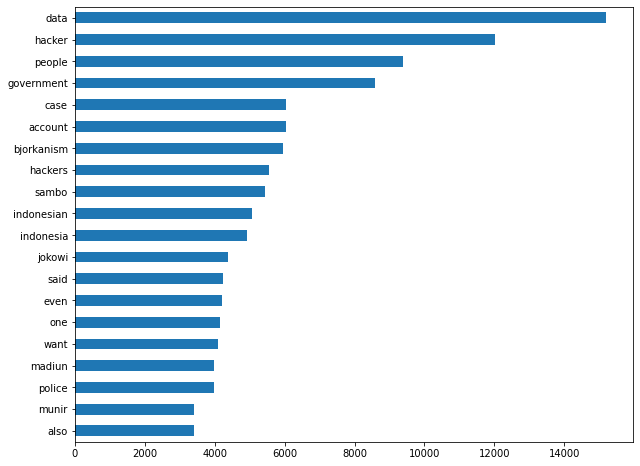

In [ ]:
plt.figure(figsize=(10,8))
bow1.sum(axis=0).sort_values(ascending=False)[:20].sort_values().plot(kind='barh')
plt.savefig('top.png')
plt.show()

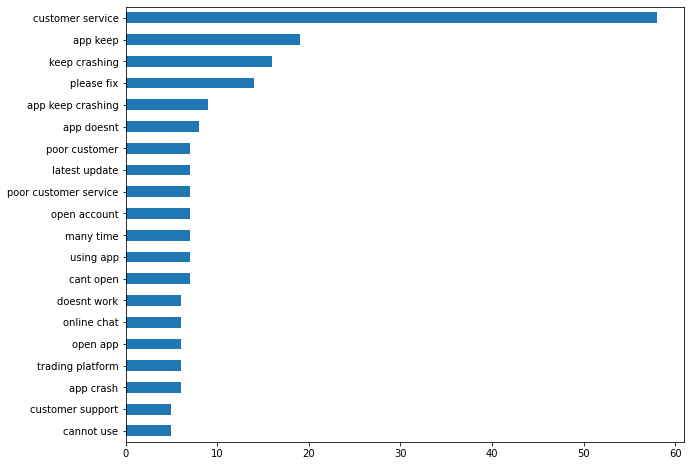

In [ ]:
plt.figure(figsize=(10,8))
bow2.sum(axis=0).sort_values(ascending=False)[:20].sort_values().plot(kind='barh')
plt.savefig(f'/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_keyword_neg',bbox_inches='tight')
plt.show()

## Thumbsup

In [ ]:
# app = 'pintu'
# folder= 'Pintu'
df = pd.read_excel(f'/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_pysentiment.xlsx')

In [ ]:
df_2 = df[(df.thumbsUpCount > 5)]

In [ ]:
tmp = df_2.sort_values(by=["pysentiment","thumbsUpCount"], ascending=[True,False])
base = pd.read_excel(f"/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_raw.xlsx")
base.loc[tmp[tmp.pysentiment==0].index].to_excel(f"/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_thumbsup_neg.xlsx",index=False)
base.loc[tmp[tmp.pysentiment==2].index].to_excel(f"/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_thumbsup_pos.xlsx",index=False)

In [ ]:
text_pos = " ".join(review for review in df_2[df_2.pysentiment==2].content)
text_neg = " ".join(review for review in df_2[df_2.pysentiment==0].content)

In [ ]:
wordcloud_pos = WordCloud(stopwords=stop_words,
                width = 800, height = 800,
                background_color ='white',min_word_length =2,
                min_font_size = 10).generate(text_pos)

wordcloud_neg = WordCloud(stopwords=stop_words,
                width = 800, height = 800,
                background_color ='white',min_word_length =2,
                min_font_size = 10).generate(text_neg)


In [ ]:
word_pos = wordcloud_pos.process_text(text_pos)
df_word_pos = pd.DataFrame(word_pos, index=['Counts']).T.reset_index().rename(columns={'index':'Words'}).sort_values(by='Counts', ascending=False)

word_neg = wordcloud_neg.process_text(text_neg)
df_word_neg = pd.DataFrame(word_neg, index=['Counts']).T.reset_index().rename(columns={'index':'Words'}).sort_values(by='Counts', ascending=False)

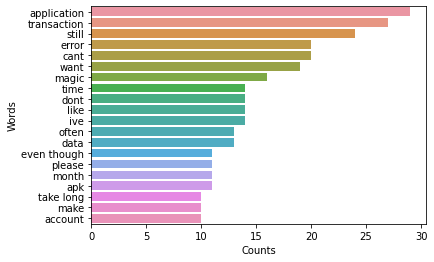

In [ ]:
sns.barplot(x='Counts',y='Words', data = df_word_neg.sort_values('Counts',ascending=False)[:20])

In [ ]:
wordcloud_pos.to_file("bibit_pos.png")
wordcloud_neg.to_file("bibit_neg.png")
# wordcloud.to_file("bibit.png")

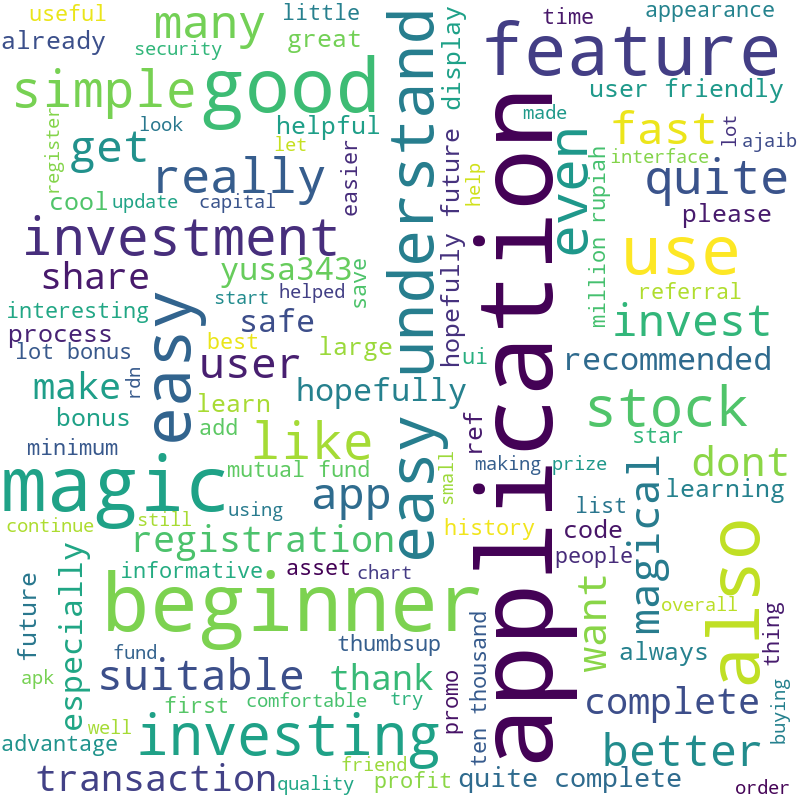

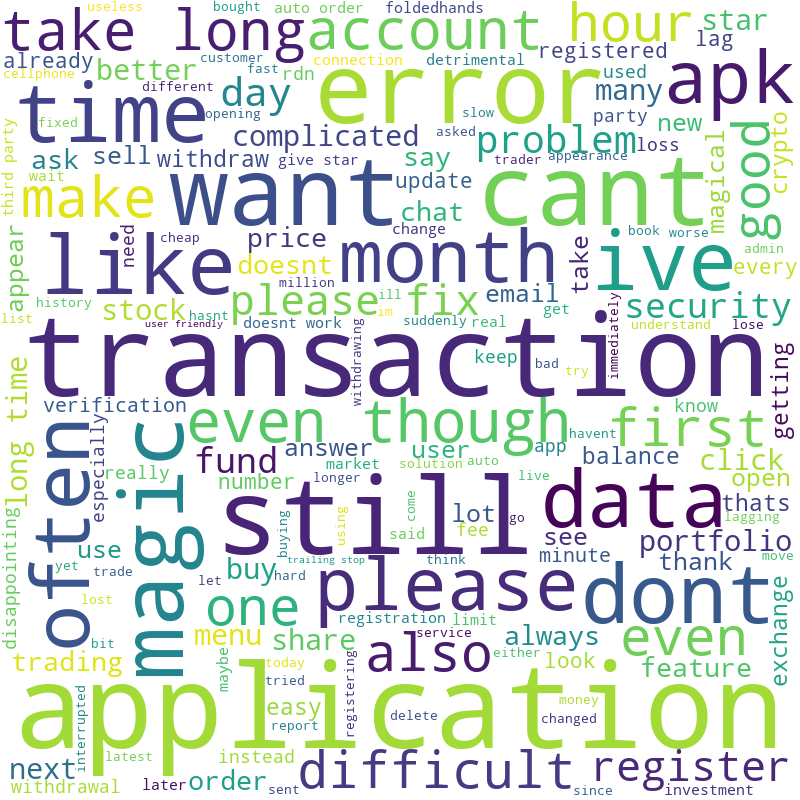

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('bibit_pos.png')
cv2_imshow(img)
print()
img = cv2.imread('bibit_neg.png')
cv2_imshow(img)

# img = cv2.imread('bibit.png')
# cv2_imshow(img)

In [ ]:
df.shape

(9974, 8)

In [ ]:
df_3.shape

(10000, 7)

In [ ]:
df_2[df_2.pysentiment==2].sort_values(by='thumbsUpCount',ascending=False)

In [ ]:
df_3 = pd.read_excel(f'/content/drive/MyDrive/Saxo 2022/6. Analytics Team/{folder}/{app}_process.xlsx')

In [ ]:
df_3.loc[11].content

"Be careful of Magic Day Trading users.... the problem account can't withdraw money"

In [ ]:
df_2[df_2.pysentiment==2].sort_values(by='thumbsUpCount',ascending=False)[:20].loc[3990].content

'0 star would given change endorsement give smooth cashback application supporting thank many user'

## Backup sentiment and shap

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
tokenizer = AutoTokenizer.from_pretrained("lvwerra/distilbert-imdb")
model = AutoModelForSequenceClassification.from_pretrained("lvwerra/distilbert-imdb")

In [ ]:
classifier = pipeline('text-classification', return_all_scores=True, model=model,tokenizer=tokenizer)

In [ ]:
df_bibit.content[0], classifier(df_bibit.content[0])

('must try download good youve registered ojk invest small cheap capital bright future afraid eh turn kang dedy magician appeared tv telling download tried liked confused want invest lot choice good service let download try good future',
 [[{'label': 'NEGATIVE', 'score': 0.36890459060668945},
   {'label': 'POSITIVE', 'score': 0.6310954093933105}]])

In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 9.9 MB/s 


In [ ]:
import shap
explainer = shap.Explainer(classifier)

In [ ]:
shap_values = explainer(df_bibit.content[:1])

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:47, 47.49s/it]               


In [ ]:
shap.plots.text(shap_values)

In [ ]:
def sentiment(x):
  score = classifier(x)[0][1]['score']
  if score >= 0.5: return 1
  else: return 0

In [ ]:
df_bibit.isnull().sum()

content                   122
score                       0
thumbsUpCount               0
reviewCreatedVersion     5715
at                          0
replyContent            36002
repliedAt               36002
dtype: int64

In [ ]:
df_bibit = df_bibit[df_bibit['content'].notnull()]

In [ ]:
df_bibit['sentiment'] = df_bibit.content.progress_apply(lambda x: sentiment(x))

100%|██████████| 40443/40443 [28:17<00:00, 23.83it/s]


In [ ]:
df_bibit.to_excel('/content/drive/MyDrive/Saxo 2022/Analytics Team/bibit_sentiment.xlsx', index=False)

In [ ]:
# # Function to calculate sentiment score for whole data set
# # Naive

# def senti_sc(x):
#     if x is not None:
#        return TextBlob(x).sentiment.polarity

# df_bibit["Sentiment_score"]= df_bibit["content"].apply(senti_sc)
# print(df_bibit.loc[0:19,['content','Sentiment_score']])

In [ ]:
from transformers import pipeline

classifier = pipeline("text-classification", model = "Souvikcmsa/BERT_sentiment_analysis")
classifier("I loved Star Wars so much!")# Positive
classifier("A soccer game with multiple males playing. Some men are playing a sport.")# Neutral

Downloading:   0%|          | 0.00/944 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'neutral', 'score': 0.9523075819015503}]

In [ ]:
df_bibit.content[6],classifier(df_bibit.content[6])

('good shame investment still limited stock crypto think much simpler invest arent many choice focus maximize daily profit really profitable download register quickly verified easy understand dont miss app like',
 [{'label': 'neutral', 'score': 0.5383983850479126}])